# **<u>CIS 9650 - SPRING 2021**</u>
## **BRAIN ATTACK (STROKE) ANALYSIS AND PREDICTION**
### **GROUP 4: Bingxuan Hu, Qiaoyi Tan, Wenyi Wang, Xin Bian, Zixin Ye, Atabay Kadiroglu**

In [686]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import percentile
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, classification_report
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import liftChart, gainsChart
import warnings
warnings.filterwarnings("ignore")

In [687]:
# loading the dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [688]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## A) <u>DATA PRE-PROCESSING<u/>
### 1) Null Values, Duplicates, and unique Rows

In [689]:
# show missing values
print(df.isnull().sum())

# how duplicates
duplicate = df[df.duplicated()]
print("Duplicate Rows:", len(duplicate), "\n")

print("Overall there are", sum(df.isnull().sum()), "missing values in bmi column and", len(duplicate), "duplicates in the dataset")

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
Duplicate Rows: 0 

Overall there are 201 missing values in bmi column and 0 duplicates in the dataset


In [690]:
# because we want to preserve the sample size in our data set
# we will replace the missing values in bmi column by the mean of non-missing values
df["bmi"].fillna(df["bmi"].mean(),inplace=True)

print("total missing values after mean imputation:", sum(df.isnull().sum()))

total missing values after mean imputation: 0


In [691]:
# print out columns and number of unique values
for col in df.columns:
    print(col, df[col].nunique())

id 5110
gender 3
age 104
hypertension 2
heart_disease 2
ever_married 2
work_type 5
Residence_type 2
avg_glucose_level 3979
bmi 419
smoking_status 4
stroke 2


In [692]:
# turns out gender column has 3 unique values with "Female", "Male", and "Other"
print(df["gender"].value_counts(), "\n")

# but since there is only one row with gender "Other", we drop this row out
df.drop(df.index[df["gender"]=="Other"], inplace=True)

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64 



In [693]:
# we also find out work_type has 4 unique values, and one of them is "children"
print(df["work_type"].value_counts())

# but since a children is also never worked, we replace "children" value with "Never_worked"
df["work_type"] = df["work_type"].replace(["children"], "Never_worked")

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


In [694]:
# next we rename the "Residence_type" with lower case initial for consistency
# and change age column into integer from float
df.rename(columns = {"Residence_type": "residence_type"}, inplace=True)
df["age"] = df["age"].astype("int")

# after that we convert all object type variables into categorical
cols = ["stroke", "gender", "hypertension", "heart_disease", "ever_married", "work_type", "residence_type", "smoking_status"]
df[cols] = df[cols].astype("category")

# and then we drop id column as it won't have any contribution to our analysis
df.drop(["id"], axis="columns", inplace=True)

# this is our dataset looks after pre-processing
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5109 non-null   category
 1   age                5109 non-null   int64   
 2   hypertension       5109 non-null   category
 3   heart_disease      5109 non-null   category
 4   ever_married       5109 non-null   category
 5   work_type          5109 non-null   category
 6   residence_type     5109 non-null   category
 7   avg_glucose_level  5109 non-null   float64 
 8   bmi                5109 non-null   float64 
 9   smoking_status     5109 non-null   category
 10  stroke             5109 non-null   category
dtypes: category(8), float64(2), int64(1)
memory usage: 200.7 KB
None


## B) <u>EXPLORATORY DATA ANALYSIS<u/>
### 1) The Frequency of Target Variable: "Stroke"

In [695]:
# "stroke" is the target variable in our dataset. 
# stroke = 1 means a patient had a stroke, stroke = 0 means patient didnt have a stroke

print(df["stroke"].value_counts(), "\n")

stroke1 = df[df["stroke"] == 1]
stroke0 = df[df["stroke"] == 0]

print("# of people didn't have a stroke:", len(stroke0))
print("# of people had a stroke:", len(stroke1))

0    4860
1     249
Name: stroke, dtype: int64 

# of people didn't have a stroke: 4860
# of people had a stroke: 249


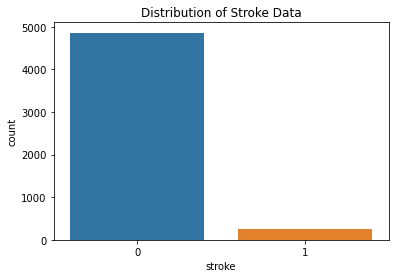

In [696]:
sns.countplot(x="stroke", data=df)
plt.title("Distribution of Stroke Data")
plt.show()

**As seen from above graph, our data-set is highly imbalanced.
We will handle this issue later when we are creating our model for prediction.**

### 2) Correlation Matrix

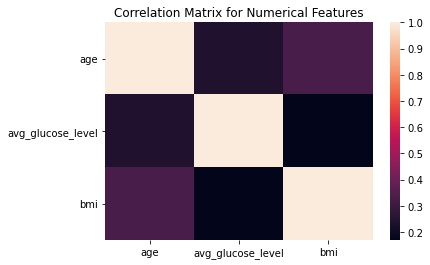

                    age  avg_glucose_level   bmi
age                1.00               0.24  0.33
avg_glucose_level  0.24               1.00  0.17
bmi                0.33               0.17  1.00


In [697]:
corr_matrix = df.corr().round(2)
sns.heatmap(corr_matrix)
plt.title("Correlation Matrix for Numerical Features")
plt.show()
print(corr_matrix)

**None of the numerical features are seem to be highly correlated.**

### 3) Observation of Numerical Features

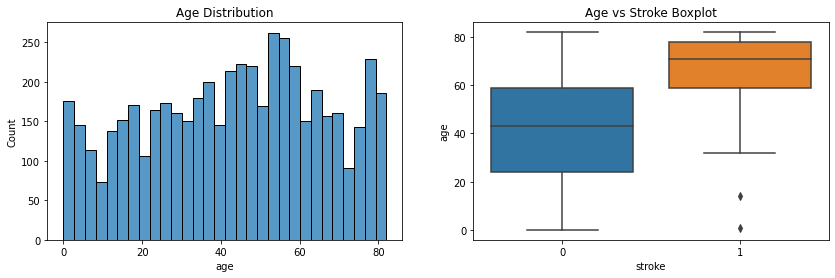

In [698]:
fig, axes = plt.subplots(1,2, figsize=(14,4))

sns.histplot(x=df["age"], data=df, bins=30, ax=axes[0])
axes[0].set_title("Age Distribution")

sns.boxplot(y=df["age"], x="stroke", data=df, ax=axes[1])
axes[1].set_title("Age vs Stroke Boxplot")
plt.show()

**We can see that median age for people who had stroke is higher than people who didn't.**

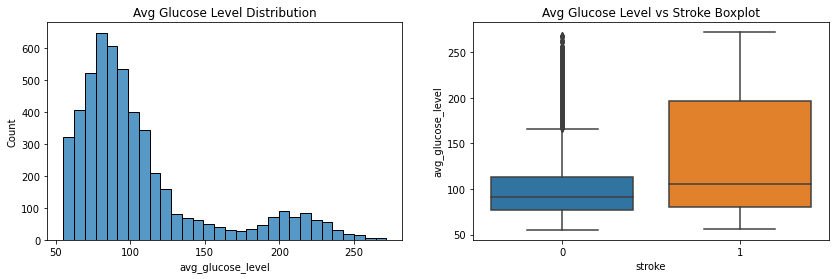

In [699]:
fig, axes = plt.subplots(1,2, figsize=(14,4))

sns.histplot(x=df["avg_glucose_level"], data=df, bins=30, ax=axes[0])
axes[0].set_title("Avg Glucose Level Distribution")

sns.boxplot(y=df["avg_glucose_level"], x="stroke", data=df, ax=axes[1])
axes[1].set_title("Avg Glucose Level vs Stroke Boxplot")
plt.show()

**Avg glucose level distribution is right_skewed with many outliers, and median value of avg glucose level is higher on people who had a stroke than those who didn't.**

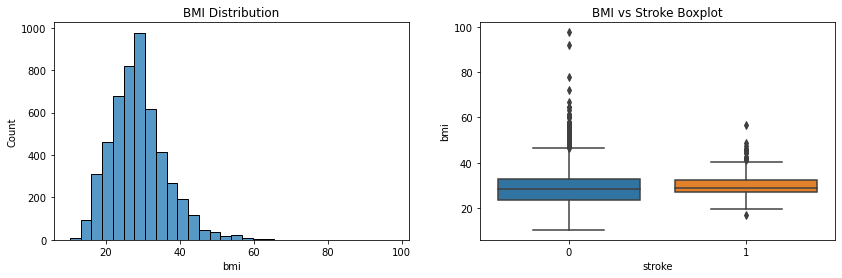

In [700]:
fig, axes = plt.subplots(1,2, figsize=(14,4))

sns.histplot(x=df["bmi"], data=df, bins=30, ax=axes[0])
axes[0].set_title("BMI Distribution")

sns.boxplot(y=df["bmi"], x="stroke", data=df, ax=axes[1])
axes[1].set_title("BMI vs Stroke Boxplot")
plt.show()

**Bmi doesn't seem to have much correlation with stroke as the median values for both categories look almost the same.**

**Also similar to avg glucose level, there are many outliers in bmi column. We will handle those outliers before we create our model.**

### 4) Observations of Categorial Features

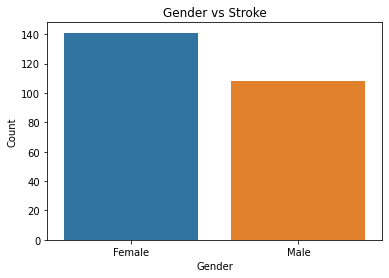

In [701]:
# gender vs stroke
sns.countplot(x="gender", data=stroke1)
plt.title("Gender vs Stroke")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

**We observe that females are slightly more likely than males to get a stroke.** 

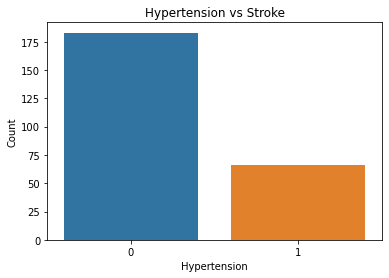

In [702]:
# hypertension vs stroke
sns.countplot(x="hypertension", data=stroke1)
plt.title("Hypertension vs Stroke")
plt.xlabel("Hypertension")
plt.ylabel("Count")
plt.show()

**Large number of people who had a stroke don't have hypertension.**

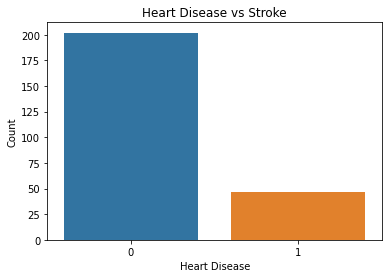

In [703]:
# heart disease vs stroke
sns.countplot(x="heart_disease", data=stroke1)
plt.title("Heart Disease vs Stroke")
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.show()

**Large number of people who had a stroke don't have any heart disease.**

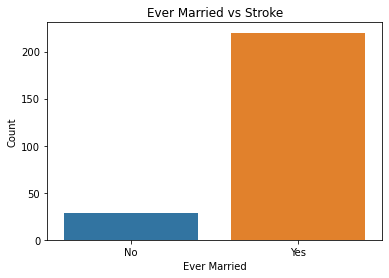

In [704]:
# ever_married vs stroke
sns.countplot(x="ever_married", data=stroke1)
plt.title("Ever Married vs Stroke")
plt.xlabel("Ever Married")
plt.ylabel("Count")
plt.show()

**Most of the people who had a stroke had also have a marriage.**

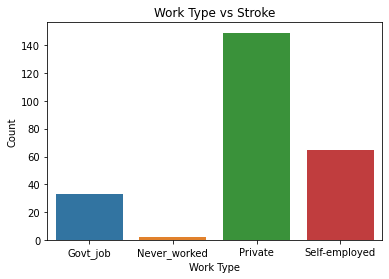

In [705]:
# work_type vs stroke
sns.countplot(x="work_type", data=stroke1)
plt.title("Work Type vs Stroke")
plt.xlabel("Work Type")
plt.ylabel("Count")
plt.show()

**Large number of people who had a stroke also work in private sector.**
**People who have never worked or have goverment jobs are less likely to get a stroke.**

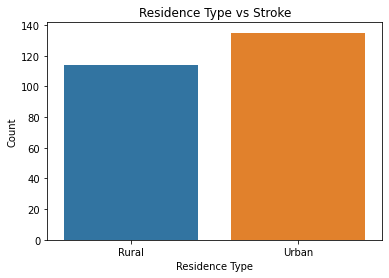

In [706]:
# residence_type vs stroke
sns.countplot(x="residence_type", data=stroke1)
plt.title("Residence Type vs Stroke")
plt.xlabel("Residence Type")
plt.ylabel("Count")
plt.show()

**More people from urban areas had a stroke than those who live in Rural areas.**

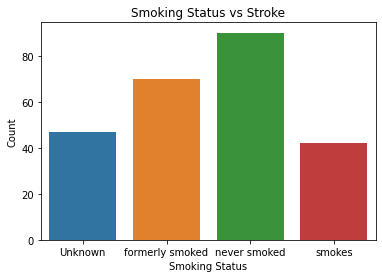

In [707]:
# smoking_status vs stroke
sns.countplot(x="smoking_status", data=stroke1)
plt.title("Smoking Status vs Stroke")
plt.xlabel("Smoking Status")
plt.ylabel("Count")
plt.show()

**Most of the people who had a stroke are those who never smoked.**
**It seems smoking status doesn't have much impact on having a stroke.**


## C) <u>DATA PREPARATION FOR MODEL BUILDING<u/>
### 1) Removing Outliers

In [708]:
# Counting outliers in each numerical column
quant_var = ["bmi", "age", "avg_glucose_level"]
outlier_count = []
print("Number of outliers in each column are as follows: ","\n")

for i in quant_var:
    # calculate interquartile range
    q25 = np.percentile(df[i], 25)
    q75 = np.percentile(df[i], 75)
    iqr = q75 - q25
    
    # calculate lower and upper limits
    low_lim = q25 - (1.5 * iqr)
    up_lim = q75 + (1.5 * iqr)
    lst = df[(df[i] < low_lim) | (df[i] > up_lim)].index
    outlier_count.append(len(lst))
    print(i + " ", len(lst))

print("\n","Total outlier count:", sum(outlier_count))

Number of outliers in each column are as follows:  

bmi  126
age  0
avg_glucose_level  627

 Total outlier count: 753


**An outlier is a data point that is distant from other observations. If not removed or imputed, these observations may skew or mislead the training process of our model.**

**As seen from above plot and calculations, there are many outliers in our dataset, particularly in avg_glucose_level and bmi columns.**

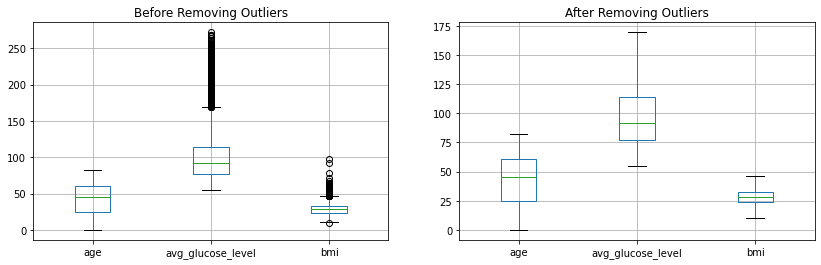

In [709]:
fig, axes = plt.subplots(1,2, figsize=(14,4))

df.boxplot(ax=axes[0])
axes[0].set_title("Before Removing Outliers")

# creating a function to replace outliers
def remove_outliers(data):
    ##calculate interquartile range
    q25 = np.percentile(data, 25)
    q75 = np.percentile(data, 75)
    iqr = q75 - q25
    
    # calculate lower and upper limits
    low_lim = q25 - (1.5 * iqr)
    up_lim = q75 + (1.5 * iqr)
    
    # identify and cap outliers
    outliers = []
    for x in data:
        if x < low_lim:
            x = low_lim
            outliers.append(x)
        elif x > up_lim:
            x = up_lim
            outliers.append(x)
        else:
            outliers.append(x)
    return outliers

# replace outliers
df["bmi"] = remove_outliers(df['bmi'])
df["avg_glucose_level"] = remove_outliers(df["avg_glucose_level"])

df.boxplot(ax=axes[1])
axes[1].set_title("After Removing Outliers")
plt.show()

**As we don't want to lose sample size, we impute the outliers by capping them with upper and lower limits.**
**For that purpose, we create "remove_outliers" function to replace the outliers with low_lim and up_lim values.**

### 2) One-Hot Encoding

In [710]:
# one-hot encoding
# get dummies and identify predictor and outcome variables
predictors = df.drop(columns = ["stroke"])
outcome = "stroke"

X = pd.get_dummies(predictors, drop_first=True)
y = df[outcome]

# Split validation
train_X, valid_X, train_y, valid_y= train_test_split(X, y, test_size=0.30, random_state=1)

**Using get_dummies method, we create additional features based on the number of unique values in each categorical variable.**
**Next, we split our data-set into train and test data, with %70 and %30 data size respectively.**

### 3) OverSampling

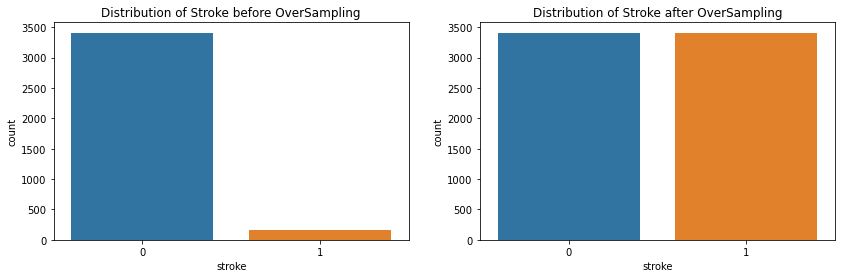

In [711]:
fig, axes = plt.subplots(1,2, figsize=(14,4))

# distribution of target variable Before oversampling
sns.countplot(x = train_y, data = df, ax=axes[0])
axes[0].set_title("Distribution of Stroke before OverSampling")

# Oversampling
smote = SMOTE()
train_X, train_y = smote.fit_resample(train_X, train_y)

# distribution of target variable After oversampling
sns.countplot(x = train_y, data = df, ax=axes[1])
axes[1].set_title("Distribution of Stroke after OverSampling")
plt.show()

**As seem from the EDA part, the frequency of the target variable was is imbalanced.**
**A highly imbalanced data may cause machine learning algorithms to have biased results. Our train model may even completely ignore the minority class.**

**To prevent such issues, we introduce Synthetic Minority Oversampling Technique, or SMOTE to balance our data set.**

## 4) <u>Comparison of Baseline Models<u/>

### 1) Decision Trees

In [712]:
# run decisiontreeclassifier
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(train_X, train_y)
plotDecisionTree(dt, feature_names=train_X.columns, class_names=dt.classes_)

# get the prediction for both train and test
prediction_train_dt = dt.predict(train_X)
prediction_valid_dt = dt.predict(valid_X)

# calculating precision, recall and F-measure
p_1 = round(precision_score(valid_y,prediction_valid_dt),3)
r_1 = round(recall_score(valid_y,prediction_valid_dt),3)
f1_1 = round(f1_score(valid_y,prediction_valid_dt),3)
a_1 = round(accuracy_score(valid_y, prediction_valid_dt),3)

print("Scores for prediction on validation set")
print("=======================================")
print("Precision score: ", p_1)
print("Recall score: ", r_1)
print("f1-score: ", f1_1)
print("Accuracy:", a_1)

Scores for prediction on validation set
Precision score:  0.131
Recall score:  0.675
f1-score:  0.219
Accuracy: 0.739


### 2) Logistics Regression

In [713]:
# run logistic regression model
logit = LogisticRegression(solver='liblinear')
logit.fit(train_X,train_y)

# predictions on training and validation set
prediction_train_log = logit.predict(train_X)
prediction_valid_log = logit.predict(valid_X)

# calculating precision, recall and F-measure
p_2 = round(precision_score(valid_y,prediction_valid_log),2)
r_2 = round(recall_score(valid_y,prediction_valid_log),2)
f1_2 = round(f1_score(valid_y,prediction_valid_log),2)
a_2 = round(accuracy_score(valid_y, prediction_valid_log),2)

print("Scores for prediction on validation set:")
print("=======================================")
print("Precision score: ", p_2)
print("Recall score: ", r_2)
print("f1-score: ", f1_2)
print("Accuracy:", a_2)

Scores for prediction on validation set:
Precision score:  0.14
Recall score:  0.36
f1-score:  0.2
Accuracy: 0.85


### 3) Naive Bayes Model

In [714]:
# run naive Bayes
nb = GaussianNB()
nb.fit(train_X,train_y)

# predict class membership
prediction_train_nb=nb.predict(valid_X)

# predict probabilities
pred_train_prob_nb = nb.predict_proba(valid_X)

# prediction accuracy on training and validation set
prediction_train_nb = nb.predict(train_X)
prediction_valid_nb = nb.predict(valid_X)

# calculating precision, recall and F-measure on valid
p_3 = precision_score(valid_y,prediction_valid_nb)
r_3 = recall_score(valid_y,prediction_valid_nb)
f1_3 = f1_score(valid_y,prediction_valid_nb)
a_3 = accuracy_score(valid_y, prediction_valid_nb)

print("Scores for prediction on validation set:")
print("=======================================")
print("Precision score: ", p_3)
print("Recall score: ", r_3)
print("f1-score: ", f1_3)
print("Accuracy:", a_3)

Scores for prediction on validation set:
Precision score:  0.08448275862068966
Recall score:  0.5903614457831325
f1-score:  0.1478129713423831
Accuracy: 0.6314416177429876


### 4) Random Forest

In [715]:
# run randomforest classifier
rf =  RandomForestClassifier(criterion = 'entropy', random_state = 42, n_estimators=500)
rf.fit(train_X,train_y)

p_4 = precision_score(valid_y,rf.predict(valid_X))
r_4 = recall_score(valid_y,rf.predict(valid_X))
f_14 = f1_score(valid_y,rf.predict(valid_X))
a_4 = accuracy_score(valid_y, rf.predict(valid_X))

print("Scores for prediction on validation set:")
print("=======================================")
print("precision score: ", p_4)
print("recall score: ", r_4)
print("f1-score: ", f1_4)
print("Accuracy:", a_4)

Scores for prediction on validation set:
precision score:  0.08108108108108109
recall score:  0.07228915662650602
f1-score:  0.0925925925925926
Accuracy: 0.9054142204827136


### 5) Comparison of Models

In [716]:
# creating lists of all scores for comparison
precision0=[p_1,p_2,p_3,p_4]
recall0=[r_1,r_2,r_3,r_4]
f1score0=[f1_1,f1_2,f1_3,f1_4]
accuracy0=[a_1,a_2,a_3,a_4,]

# dataframe for comparison
df_metrics0=pd.DataFrame({
    "Classifier":[
        "Decision Tree Classifier","Logistic Regression","Naive Bayes","Random Forest",
    ],"Precision":precision0,"Recall":recall0,"F1-score":f1score0,"Accuracy":accuracy0})

print(df_metrics0)

                 Classifier  Precision    Recall  F1-score  Accuracy
0  Decision Tree Classifier   0.131000  0.675000  0.219000  0.739000
1       Logistic Regression   0.140000  0.360000  0.200000  0.850000
2               Naive Bayes   0.084483  0.590361  0.147813  0.631442
3             Random Forest   0.081081  0.072289  0.092593  0.905414


## D) <u>FEATURE SELECTION<u/>

In [717]:
import statsmodels.api as sm
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

print(forward_selection(X,y))

['age', 'work_type_Never_worked', 'heart_disease_1', 'avg_glucose_level', 'ever_married_Yes', 'hypertension_1', 'work_type_Private']


**Feature selection is a process of selecting the most significant and relevant features from a dataset.**
**This process is needed to eliminate less important and irrelevant features which lead to inaccurate predictions for our model.**

**In forward selection method, we start fitting the model with each feature one at a time and choose the feature with mininum p value.**
**We repeat this process combining with previously chosen features till we have a set of features with p values less than the significance level (0.05).**

In [718]:
# choosing the best features for our training data
X_for_selected=X[['age',
 'work_type_Never_worked',
 'heart_disease_1',
 'avg_glucose_level',
 'ever_married_Yes',
 'hypertension_1',
 'work_type_Private']]

# splitting the dataset
trainx, validx, trainy, validy = train_test_split(X_for_selected,y,test_size=0.30, random_state=1)

**Here in our case, the best features for our data set are as follows:
'age', 'work_type_Never_worked', 'heart_disease_1', 'avg_glucose_level', 'ever_married_Yes', 'hypertension_1', 'work_type_Private'**

**Next, selecting the best features we create a new train and test splits, again with %70 and %30 data size, and apply them into our models.**

### 1) Decision Trees with Best Selected Features

In [719]:
# run decisiontreeclassifier
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(trainx, trainy)
plotDecisionTree(dt, feature_names=trainx.columns, class_names=dt.classes_)

# get the prediction for both train and test
prediction_train_dt = dt.predict(trainx)
prediction_valid_dt = dt.predict(validx)

# calculating precision, recall and F-measure
p1 = round(precision_score(validy,prediction_valid_dt),3)
r1 = round(recall_score(validy,prediction_valid_dt),3)
f11 = round(f1_score(validy,prediction_valid_dt),3)
a1 = round(accuracy_score(validy, prediction_valid_dt),3)

print("DecisionTree Scores for prediction on validation set")
print("=======================================")
print("Precision score: ", p1)
print("Recall score: ", r1)
print("f1-score: ", f11)
print("Accuracy:", a1)

DecisionTree Scores for prediction on validation set
Precision score:  0.25
Recall score:  0.012
f1-score:  0.023
Accuracy: 0.945


### 2) Logistics Regression with Best Selected Features

In [720]:
# run logisticsRegression model
logit = LogisticRegression(solver='liblinear')
logit.fit(trainx, trainy)

# predictions on training and validation set
prediction_train_log = logit.predict(trainx)
prediction_valid_log = logit.predict(validx)

# calculating precision, recall and F-measure
p2 = round(precision_score(validy,  prediction_valid_log),2)
r2 = round(recall_score(validy,prediction_valid_log),2)
f12 = round(f1_score(validy, prediction_valid_log),2)
a2 = round(accuracy_score(validy, prediction_valid_log),2)

print("Logistics Regression Scores for prediction on validation set:")
print("=======================================")
print("Precision score: ", p2)
print("Recall score: ", r2)
print("f1-score: ", f12)
print("Accuracy:", a2)

Logistics Regression Scores for prediction on validation set:
Precision score:  0.0
Recall score:  0.0
f1-score:  0.0
Accuracy: 0.95


### 3) Naive Bayes with Best Selected Features

In [721]:
#run naive Bayes
nb = GaussianNB()
nb.fit(trainx,trainy)

##predict class membership
prediction_train_nb = nb.predict(validx)

##predict probabilities
pred_train_prob_nb = nb.predict_proba(validx)

##Prediction accuracy on training and validation set
prediction_train_nb = nb.predict(trainx)
prediction_valid_nb = nb.predict(validx)

#Calculating precision, recall and F-measure on valid
p3 = precision_score(validy,prediction_valid_nb)
r3 = recall_score(validy,prediction_valid_nb)
f13 = f1_score(validy,prediction_valid_nb)
a3 = accuracy_score(validy, prediction_valid_nb)

print("Naive Bayes Scores for prediction on validation set:")
print("=======================================")
print("Precision score: ", p3)
print("Recall score: ", r3)
print("f1-score: ", f13)
print("Accuracy:", a3)

Naive Bayes Scores for prediction on validation set:
Precision score:  0.19138755980861244
Recall score:  0.4819277108433735
f1-score:  0.273972602739726
Accuracy: 0.8617090671885193


### 4) Random Forest with Best Selected Features

In [722]:
# run randomforest classifier
rf=RandomForestClassifier(criterion = 'entropy', random_state = 42, n_estimators=500)
rf.fit(trainx, trainy)

p4 = precision_score(validy,rf.predict(validx))
r4 = recall_score(validy,rf.predict(validx))
f14 = f1_score(validy,rf.predict(validx))
a4 = accuracy_score(validy, rf.predict(validx))

print("Random Forest Scores for prediction on validation set:")
print("=======================================")
print("precision score: ", p4)
print("recall score: ", r4)
print("f1-score: ", f14)
print("Accuracy:", a4)

Random Forest Scores for prediction on validation set:
precision score:  0.24
recall score:  0.07228915662650602
f1-score:  0.11111111111111109
Accuracy: 0.9373776908023483


### 5) Comparison of Models After Feature Selection

In [723]:
# creating lists of all scores for comparison
precision1=[p1,p2,p_3,p4]
recall1=[r1,r2,r_3,r4]
f1score1=[f11,f12,f13,f14]
accuracy1=[a1,a2,a3,a4]

# dataframe for comparison
df_metrics1=pd.DataFrame({
    "Classifier":[
        "Decision Tree Classifier","Logistic Regression","Naive Bayes","Random Forest",
    ],"Precision":precision1,"Recall":recall1,"F1-score":f1score1,"Accuracy":accuracy1})

print(df_metrics1)

                 Classifier  Precision    Recall  F1-score  Accuracy
0  Decision Tree Classifier   0.250000  0.012000  0.023000  0.945000
1       Logistic Regression   0.000000  0.000000  0.000000  0.950000
2               Naive Bayes   0.084483  0.590361  0.273973  0.861709
3             Random Forest   0.240000  0.072289  0.111111  0.937378


**Although accuracy score is the most intuitive performance measure, as it is the ratio of correctly predicted observations to total observations, we still need to look at other parameters such as Recall and F1-score to evaluate the performance of our models.**

**The model with highest F1-score, Accuracy, and Recall score after the feature selection is Naive Bayes. The reason we are focusing on F1-score and Recall score for our model is <u>because we want to keep the number of False Negatives as small as possible<u/>.**

In [725]:
classificationSummary(validy, prediction_valid_nb)

Confusion Matrix (Accuracy 0.8617)

       Prediction
Actual    0    1
     0 1281  169
     1   43   40


Above you can see the distribution of confusion matrix in our Naive Bayes Model. 
    
**True Negative**: 1281 people were predicted to not have a stroke, and didn't have a stroke.  
**True Positive**: 40 people were predicted to have a stroke, and did have a stroke.  
**False Negative**: 43 people were predicted to not have a stroke, but did have a stroke.  
**False Positive**: 169 people were predicted to have a stroke, but didn't have a stroke.

Please note that Recall score is calculated by True Positives(TP) divided by Total Actual Positives (TP + FN),  
and Precision score is calculated by True Positives(TP) divided by the Total Predicted Positives (TP + FP).  
Additionally, F1-score is the weighted average of Precision and Recall.

**As conclusion, applying feature selection method to our base-models we have succesfully improved our Naive Bayes Model with %32 increase in Accuracy and %80 increase in F1-score.**

**Additionally we have selected the best possible features to use in our stroke prediction program**

'age', 'work_type_Never_worked', 'heart_disease_1', 'avg_glucose_level', 'ever_married_Yes', 'hypertension_1', 'work_type_Private'

**Next focusing on the these features we will write our Stroke Prediction Program to measure the likelihood of someone getting a stroke based on our Naive Bayes Model.**